# Setup

In [1]:
!rm -rf Painter
!git clone https://github.com/baaivision/Painter

%mv Painter/SegGPT/SegGPT_inference/ ./seggpt
!touch seggpt/__init__.py

!rm -rf Painter

!rm seggpt_vit_large.pth
!wget https://huggingface.co/BAAI/SegGPT/resolve/main/seggpt_vit_large.pth

Cloning into 'Painter'...
remote: Enumerating objects: 287, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 287 (delta 29), reused 24 (delta 23), pack-reused 232
Receiving objects: 100% (287/287), 13.07 MiB | 34.06 MiB/s, done.
Resolving deltas: 100% (76/76), done.
mv: cannot move 'Painter/SegGPT/SegGPT_inference/' to './seggpt/SegGPT_inference': Directory not empty
--2023-07-22 15:18:25--  https://huggingface.co/BAAI/SegGPT/resolve/main/seggpt_vit_large.pth
Resolving huggingface.co (huggingface.co)... 18.172.134.88, 18.172.134.124, 18.172.134.4, ...
Connecting to huggingface.co (huggingface.co)|18.172.134.88|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/a0/5c/a05ca640d6e4f08b928489d7e7f80507590b071210c55fc80e463f64c139936c/59c74d1993ca50ac0ae968d9bbe5db453f50aa5d5c7c9564cce6011c18b16570?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%

In [2]:
with open("seggpt/seggpt_engine.py","r") as f:
  txt = f.read()

with open("seggpt/seggpt_engine.py","w") as f:
  f.write(txt.replace("(input_image * (0.6 * output / 255 + 0.4))","output"))

In [3]:
!pip install -q timm fairscale git+https://github.com/facebookresearch/detectron2.git

In [4]:
!pip uninstall -y nvidia_cublas_cu11

Found existing installation: nvidia-cublas-cu11 11.10.3.66
Uninstalling nvidia-cublas-cu11-11.10.3.66:
  Successfully uninstalled nvidia-cublas-cu11-11.10.3.66


In [5]:
!pip install palettable
from palettable.wesanderson import FantasticFox2_5

# Roboflow datasets

In [6]:
!rm -rf datasets/
!mkdir datasets/

In [7]:
!pip install -q roboflow pycocotools
from roboflow import Roboflow
rf = Roboflow(api_key="YsWaBWdLsFfUXb1x0YdP")


In [8]:
# %cd datasets/

# project = rf.workspace("amala02").project("cancer-detection-xmvfg")
# !rm -rf ./datasets/Cancer-Detection-*
# dataset = project.version(4).download("coco-segmentation")

# %cd ../


In [9]:
%cd datasets/
project = rf.workspace("roboflow-4rfmv").project("climbing-y56wy")
!rm -rf Climbing-*/
dataset = project.version(5).download("coco-segmentation")
%cd ../

/home/andrewhealey/autodistill-seggpt/datasets
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Climbing-5 in coco-segmentation:: 100%|██████████| 51/51 [00:00<00:00, 3752.73it/s]

/home/andrewhealey/autodistill-seggpt


# Imports

In [3]:
multi_fs_scores = {}

In [4]:
from math import floor
from random import random
import numpy as np
def random_rgb():
  return np.asarray([floor(random()*256) for i in range(3)])
random_rgb()

array([128, 250, 213])

In [5]:
from palettable.wesanderson import Moonrise7_5

curr_idx = 0
def moonrise_rgb():
  global curr_idx
  ret = Moonrise7_5.colors[curr_idx]
  curr_idx = (curr_idx + 1) % len(Moonrise7_5.colors)
  return np.asarray(list(ret))

def reset_colors():
  global curr_idx
  curr_idx = 0


In [6]:
next_rgb = moonrise_rgb

In [7]:
from PIL import Image
def cv2_imshow(img):
    pil_image = Image.fromarray(img)
    return pil_image

In [8]:

import os
import cv2
import numpy as np
from pycocotools.coco import COCO
from random import seed,shuffle


In [9]:

import torch

from seggpt.seggpt_engine import inference_image, inference_video
from seggpt import models_seggpt

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def prepare_model(chkpt_dir, arch='seggpt_vit_large_patch16_input896x448', seg_type='instance'):
    # build model
    model = getattr(models_seggpt, arch)()
    model.seg_type = seg_type
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    model.eval()
    return model

from glob import glob
from tqdm import tqdm

ckpt_path = 'seggpt_vit_large.pth'
device = torch.device("cuda")
model = "seggpt_vit_large_patch16_input896x448"
seg_type = "instance"

device = torch.device(device)
model = prepare_model(ckpt_path, model, seg_type).to(device)
print('Model loaded.')


/home/andrewhealey/autodistill-seggpt/.venv/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model loaded.


In [10]:

eps = 1e-10

def semseg_iou(gt_mask_dir: str, output_dir: str, as_bitmask:bool=False):
    running_intersection = 0
    running_union = 0
    running_iou = 0
    num_imgs = 0

    for filename in os.listdir(gt_mask_dir):
        gt_mask_path = os.path.join(gt_mask_dir,filename)
        gt_mask_name = ".".join(filename.split(".")[:-1])
        output_mask_path = os.path.join(output_dir, gt_mask_name + ".png")
        if os.path.exists(output_mask_path):
            output_mask = cv2.imread(output_mask_path) > 0.2
            gt_mask = cv2.imread(gt_mask_path) > 0.2

            if as_bitmask:
              output_mask = np.any(output_mask,axis=2)
              gt_mask = np.any(gt_mask,axis=2)

            intersection = np.logical_and(output_mask, gt_mask).sum()
            union = np.logical_or(output_mask, gt_mask).sum()

            running_intersection += intersection
            running_union += union

            iou = intersection / (union + eps)
            running_iou += iou
            num_imgs += 1

    iou = running_intersection / (running_union + eps)

    return iou,running_iou/num_imgs

print("Done with imports")

Done with imports


# Single SegGPT call

In [ ]:
import os
import cv2
import numpy as np
from pycocotools.coco import COCO
data_dir = "datasets/Cancer-Detection-4/train"
ref_limit = 2

new_data_dir = "new_data"
!rm -rf $new_data_dir
!mkdir $new_data_dir

# We designate our *own* "train"/"test" directories--there will be a few images in train/, and most images in test/.
new_train_dir = os.path.join(new_data_dir,"train")
new_test_dir = os.path.join(new_data_dir,"test")
!mkdir $new_train_dir $new_test_dir

ann_file = os.path.join(data_dir,"_annotations.coco.json")
coco=COCO(ann_file)

ref_ann_dir = os.path.join(new_train_dir,"Annotations")
ref_img_dir = os.path.join(new_train_dir,"Images")
test_ann_dir = os.path.join(new_test_dir,"Annotations")
test_img_dir = os.path.join(new_test_dir,"Images")
!mkdir $test_ann_dir $test_img_dir $ref_ann_dir $ref_img_dir

cat_colors = {catId: random_rgb() for catId in coco.getCatIds()}

num_train_imgs = 0
for imgId in coco.getImgIds():

  ann_dir = ref_ann_dir if num_train_imgs < ref_limit else test_ann_dir
  img_dir = ref_img_dir if num_train_imgs < ref_limit else test_img_dir

  img = coco.imgs[imgId]
  img_path = os.path.join(data_dir,img["file_name"])
  img_cv2 = cv2.imread(img_path)

  str_imgId = str(imgId).zfill(3)
  new_img_path = os.path.join(img_dir,f"{str_imgId}.jpg")

  !cp $img_path $new_img_path

  mask = None#np.zeros_like(img_cv2)
  mask_path = os.path.join(ann_dir,f"{str_imgId}.png")
  for annId in coco.getAnnIds(imgIds=[imgId]):
    ann = coco.anns[annId]
    catId = ann["category_id"]

    ann_mask = coco.annToMask(ann)[:,:,None]
    ann_mask = np.repeat(ann_mask,3,axis=-1) * cat_colors[catId][None,None,:]
    ann_mask = ann_mask.astype("uint8")

    if mask is None:
      mask = ann_mask
    else:
      mask += ann_mask

  cv2.imwrite(mask_path,mask)
  num_train_imgs += 1


In [ ]:

input_images = glob("new_data/test/Images/*")

prompt_images = glob("new_data/train/Images/*")
prompt_masks = glob("new_data/train/Annotations/*")
output_dir = "output/"

!rm -rf old_output/
!cp -r $output_dir/ old_output/
!rm -rf $output_dir
!mkdir -p $output_dir

for input_image in tqdm(input_images):
    img_name = os.path.basename(input_image)
    out_path = os.path.join(output_dir, '.'.join(img_name.split('.')[:-1]) + '.png')
    inference_image(model, device, input_image, prompt_images, prompt_masks, out_path)

print('Finished.')

In [ ]:
# from common import *
# from load import *


output_dir = "./output"
gt_dir = "./new_data/test/Annotations"

running_iou = 0
running_iou_2 = 0
num_dirs = 0

# for output_dir in glob(output_dir_glob):
#     matching_gt_dirs = [
#         d for d in gt_dirs if os.path.basename(d) == os.path.basename(output_dir)
#     ]
#     assert len(matching_gt_dirs) == 1,f"Missing GT dir for {output_dir}. GT dirs are {gt_dirs}"
#     gt_dir = matching_gt_dirs[0]

iou,iou_2 = semseg_iou(gt_dir, output_dir)
g = os.path.basename(gt_dir)
print(f"{g}: {round(iou,3)}/{round(iou_2,3)}")
num_dirs += 1
running_iou += iou
running_iou_2 += iou_2

miou = running_iou / (num_dirs + eps)
miou_2 = running_iou_2 / (num_dirs + eps)
print(f"mIoU: {round(miou,3)}/{round(miou_2,3)}")


# Multiple SegGPT Calls

In [10]:
data_dir = "datasets/Climbing-5/train"
ref_limit = 2

ann_file = os.path.join(data_dir,"_annotations.coco.json")
coco=COCO(ann_file)

new_data_superdir = "new_multi_data"

def load_multi_data():

  !rm -rf $new_data_superdir
  !mkdir $new_data_superdir

  for catId in coco.getCatIds():
    cat = coco.cats[catId]
    name = cat["name"]
    name = f"{catId}-{name}"
    print("Category:",name)

    if len(coco.getAnnIds(catIds=[catId])) == 0:
      print(f"Skipping category {name}")
      continue

    new_data_dir = os.path.join(new_data_superdir,name)
    !mkdir $new_data_dir

    # We designate our *own* "train"/"test" directories--there will be a few images in train/, and most images in test/.
    new_train_dir = os.path.join(new_data_dir,"train")
    new_test_dir = os.path.join(new_data_dir,"test")
    !mkdir $new_train_dir $new_test_dir

    ref_ann_dir = os.path.join(new_train_dir,"Annotations")
    ref_img_dir = os.path.join(new_train_dir,"Images")
    test_ann_dir = os.path.join(new_test_dir,"Annotations")
    test_img_dir = os.path.join(new_test_dir,"Images")
    !mkdir $test_ann_dir $test_img_dir $ref_ann_dir $ref_img_dir

    num_train_imgs = 0
    imgIds = coco.getImgIds()
    shuffle(imgIds)
    for imgId in imgIds:

      allAnnIds = coco.getAnnIds(imgIds=[imgId],catIds=[catId])
      is_train_img = len(allAnnIds) > 0 and num_train_imgs < ref_limit

      ann_dir = ref_ann_dir if is_train_img else test_ann_dir
      img_dir = ref_img_dir if is_train_img else test_img_dir

      img = coco.imgs[imgId]
      img_path = os.path.join(data_dir,img["file_name"])
      img_cv2 = cv2.imread(img_path)

      str_imgId = str(imgId).zfill(3)
      new_img_path = os.path.join(img_dir,f"{str_imgId}.jpg")

      !cp $img_path $new_img_path

      mask = np.zeros((640,640,3)).astype("uint8")
      mask_path = os.path.join(ann_dir,f"{str_imgId}.png")
      ann_mask = None

      reset_colors()
      for annId in allAnnIds:
        ann = coco.anns[annId]

        instance_color = next_rgb()

        ann_mask = coco.annToMask(ann)[:,:,None]
        ann_mask = np.repeat(ann_mask,3,axis=-1) * instance_color[None,None,:]
        ann_mask = ann_mask.astype("uint8")

        mask += ann_mask

      cv2.imwrite(mask_path,mask)
      if is_train_img:
        num_train_imgs += 1


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [40]:
palette = Moonrise7_5.colors
palette = np.asarray([list(color) for color in palette])

def quantize(img):
    global palette

    # quantize image to palette
    img = np.asarray(img)

    cosine = np.sum(img[...,None,:] * palette[None,None,...],axis=-1)
    cosine = cosine / (np.linalg.norm(img,axis=-1,keepdims=True) * np.linalg.norm(palette,axis=-1)[None,None,:] + eps)

    idx = np.argmax(cosine,axis=-1)

    # set black pixels as any pixel that is not close to any color in the palette
    black_dist = np.linalg.norm(img,axis=-1)
    idx[black_dist < 40] = len(palette)

    new_palette = np.concatenate([palette,[[0,0,0]]],axis=0)

    img = new_palette[idx]
    return img.astype("uint8")

from scipy.ndimage.measurements import label

def quantized_to_bitmasks(img):
    # get "components" of each color
    filtered_components = []
    for color_idx in range(palette.shape[0]):
        color = palette[color_idx]
        matching_pixels = np.all(img == color,axis=-1)
        # now make components
        componentized, num_components = label(matching_pixels)

        for component_idx in range(1,num_components+1):
            component = componentized == component_idx
            filtered_components.append(component)
    
    filtered_components = [(component * 255).astype("uint8") for component in filtered_components]
    return filtered_components

import supervision as sv
def bitmasks_to_detections(bitmasks,catId):
    detections = [sv.Detections(
        xyxy=sv.detection.utils.mask_to_xyxy(bitmask[None,...]),
        mask=bitmask[None,...],
        confidence=np.ndarray([1]),
        class_id=np.ndarray([catId]).astype("int64"),
    ) for bitmask in bitmasks]
    return detections

# demo_mask = cv2.imread("output/1-climbing-holds/010.png")
# demo_mask = cv2.cvtColor(demo_mask,cv2.COLOR_BGR2RGB)
# demo_quant = quantize(demo_mask)
# demo_bitmasks = quantized_to_bitmasks(demo_quant)
# demo_detections = sv.Detections.merge(bitmasks_to_detections(demo_bitmasks,1))

# annotator = sv.MaskAnnotator()
# scene = cv2.imread("new_multi_data/1-climbing-holds/test/Images/010.jpg")
# scene = cv2.cvtColor(scene,cv2.COLOR_BGR2RGB)
# cv2_imshow(annotator.annotate(
#     scene=scene,
#     detections=demo_detections,
# ))


In [11]:
output_superdir="output/"
catDatasets = None

coco_outdir = "coco_output/"

def infer_multi_data():
  global catDatasets
  catDatasets = {}

  # semseg-like output predictions
  !rm -rf old_output/
  !cp -r $output_superdir/ old_output/
  !rm -rf $output_superdir
  !mkdir -p $output_superdir

  # COCO-like output predictions
  !rm -rf old_coco_output/
  !mv $coco_outdir/ old_coco_output/
  !mkdir -p $coco_outdir

  # maps image IDs to a list of detections
  # imgDetections = []

  for catId in coco.getCatIds():
    cat = coco.cats[catId]
    name = cat["name"]
    name = f"{catId}-{name}"
    print(f"Inferencing {name}")

    new_data_dir = os.path.join(new_data_superdir,name)

    input_images = glob(new_data_dir+"/test/Images/*")

    prompt_images = glob(new_data_dir + "/train/Images/*")
    prompt_masks = glob(new_data_dir + "/train/Annotations/*")
    output_dir = os.path.join(output_superdir,name)

    catDatasets[name] = [mask.split(os.sep)[-1] for mask in prompt_masks]

    !mkdir -p $output_dir

    for input_image in tqdm(input_images):
        img_name = os.path.basename(input_image)
        out_path = os.path.join(output_dir, '.'.join(img_name.split('.')[:-1]) + '.png')
        output = inference_image(model, device, input_image, prompt_images, prompt_masks, out_path)
        quant_output = quantize(output)
        bitmasks = quantized_to_bitmasks(quant_output)
        detections += bitmasks_to_detections(bitmasks, catId)
        # if img_name not in imgDetections:
        #   imgDetections[img_name] = []
        # imgDetections[img_name] += detections

    
  # for img_name in tqdm(imgDetections):
  #   detections = sv.Detections.merge(imgDetections[img_name])
    


    print('Finished.')

In [12]:

output_dir_glob = "./output/*"
gt_dir = "./new_multi_data/*/test/Annotations"
gt_dirs = glob(gt_dir)

def eval_multi_data():
  running_iou = 0
  running_iou_2 = 0
  num_dirs = 0

  catIous = {}

  for output_dir in glob(output_dir_glob):
      cls = output_dir.split(os.sep)[2]
      matching_gt_dirs = [
          d for d in gt_dirs if d.split(os.sep)[2] == cls
      ]
      if len(matching_gt_dirs) == 0:
        print("Skipping",cls)
        continue
      assert len(matching_gt_dirs) == 1,f"Missing GT dir for {output_dir}. GT dirs are {gt_dirs}"
      gt_dir = matching_gt_dirs[0]

      iou,iou_2 = semseg_iou(gt_dir, output_dir,as_bitmask=True)
      g = os.path.basename(gt_dir)
      print(f"{cls}: {round(iou,3)}/{round(iou_2,3)}")
      num_dirs += 1
      running_iou += iou
      running_iou_2 += iou_2

      catIous[cls] = (iou,iou_2)

      multi_fs_scores[cls] = [*multi_fs_scores.get(cls,[]),(catIous[cls],catDatasets[cls])]

  miou = running_iou / (num_dirs + eps)
  miou_2 = running_iou_2 / (num_dirs + eps)
  print(f"mIoU: {round(miou,3)}/{round(miou_2,3)}")


In [14]:
load_multi_data()
print("loaded")
infer_multi_data()
print("inferred")
eval_multi_data()

Category: 0-climbing-holds
Skipping category 0-climbing-holds
Category: 1-climbing-holds
Category: 2-floor
Category: 3-person
loaded
Inferencing 0-climbing-holds


0it [00:00, ?it/s]

Finished.
Inferencing 1-climbing-holds



100%|██████████| 29/29 [00:44<00:00,  1.55s/it]


Finished.
Inferencing 2-floor


100%|██████████| 29/29 [00:41<00:00,  1.45s/it]


Finished.
Inferencing 3-person


100%|██████████| 29/29 [00:42<00:00,  1.46s/it]


Finished.
inferred
2-floor: 0.008/0.004
1-climbing-holds: 0.071/0.064
3-person: 0.745/0.605
Skipping 0-climbing-holds
mIoU: 0.274/0.224


In [15]:
multi_fs_scores

{'2-floor': [((0.8270116577039338, 0.5325168310277313),
   ['028.png', '027.png']),
  ((0.7793104060232438, 0.4390267944103111), ['027.png', '001.png']),
  ((0.8773692507811183, 0.5250021492331021), ['026.png', '027.png']),
  ((0.13104579963022087, 0.10128776644709994), ['027.png', '024.png']),
  ((0.014476923673851564, 0.009640188997470826), ['028.png', '029.png']),
  ((0.7976855571019389, 0.5083103015663305), ['017.png', '024.png']),
  ((0.007538319181045177, 0.003519734331946857), ['028.png', '029.png'])],
 '1-climbing-holds': [((0.451158441513877, 0.41397490379142615),
   ['021.png', '001.png']),
  ((0.07063277128862094, 0.061001018364257475), ['026.png', '018.png']),
  ((0.3464013851766235, 0.34600251153119077), ['007.png', '003.png']),
  ((0.040924330799188585, 0.0414314278072386), ['026.png', '028.png']),
  ((0.09953889694688792, 0.0974581018027288), ['003.png', '029.png']),
  ((0.08060908437342904, 0.07342028048643573), ['007.png', '023.png']),
  ((0.07094558578500952, 0.064232

In [17]:
print("STARTING")
for seed in range(10):
    print("-"*50+f"LOADING #{seed}"+"-"*50)
    load_multi_data()
    print("-"*50+f"LOADING #{seed}"+"-"*50)
    infer_multi_data()
    print("-"*50+f"EVALLING #{seed}"+"-"*50)
    eval_multi_data()

STARTING
--------------------------------------------------LOADING #0--------------------------------------------------
Category: 0-climbing-holds
Skipping category 0-climbing-holds
Category: 1-climbing-holds
Category: 2-floor
Category: 3-person
--------------------------------------------------LOADING #0--------------------------------------------------
Inferencing 0-climbing-holds


0it [00:00, ?it/s]

Finished.
Inferencing 1-climbing-holds



100%|██████████| 29/29 [00:43<00:00,  1.51s/it]


Finished.
Inferencing 2-floor


100%|██████████| 29/29 [00:41<00:00,  1.44s/it]


Finished.
Inferencing 3-person


100%|██████████| 29/29 [00:42<00:00,  1.47s/it]


Finished.
--------------------------------------------------EVALLING #0--------------------------------------------------
2-floor: 0.791/0.503
1-climbing-holds: 0.087/0.087
3-person: 0.795/0.642
Skipping 0-climbing-holds
mIoU: 0.558/0.411
--------------------------------------------------LOADING #1--------------------------------------------------
Category: 0-climbing-holds
Skipping category 0-climbing-holds
Category: 1-climbing-holds
Category: 2-floor
Category: 3-person
--------------------------------------------------LOADING #1--------------------------------------------------
Inferencing 0-climbing-holds


0it [00:00, ?it/s]

Finished.
Inferencing 1-climbing-holds



100%|██████████| 29/29 [00:43<00:00,  1.50s/it]


Finished.
Inferencing 2-floor


100%|██████████| 29/29 [00:41<00:00,  1.44s/it]


Finished.
Inferencing 3-person


100%|██████████| 29/29 [00:42<00:00,  1.47s/it]


Finished.
--------------------------------------------------EVALLING #1--------------------------------------------------
2-floor: 0.268/0.179
1-climbing-holds: 0.075/0.08
3-person: 0.802/0.644
Skipping 0-climbing-holds
mIoU: 0.382/0.301
--------------------------------------------------LOADING #2--------------------------------------------------
Category: 0-climbing-holds
Skipping category 0-climbing-holds
Category: 1-climbing-holds
Category: 2-floor
Category: 3-person
--------------------------------------------------LOADING #2--------------------------------------------------
Inferencing 0-climbing-holds


0it [00:00, ?it/s]

Finished.
Inferencing 1-climbing-holds



100%|██████████| 29/29 [00:43<00:00,  1.50s/it]


Finished.
Inferencing 2-floor


100%|██████████| 29/29 [00:41<00:00,  1.45s/it]


Finished.
Inferencing 3-person


100%|██████████| 29/29 [00:42<00:00,  1.46s/it]


Finished.
--------------------------------------------------EVALLING #2--------------------------------------------------
2-floor: 0.854/0.509
1-climbing-holds: 0.405/0.426
3-person: 0.658/0.562
Skipping 0-climbing-holds
mIoU: 0.639/0.499
--------------------------------------------------LOADING #3--------------------------------------------------
Category: 0-climbing-holds
Skipping category 0-climbing-holds
Category: 1-climbing-holds
Category: 2-floor
Category: 3-person
--------------------------------------------------LOADING #3--------------------------------------------------
Inferencing 0-climbing-holds


0it [00:00, ?it/s]

Finished.
Inferencing 1-climbing-holds



100%|██████████| 29/29 [00:43<00:00,  1.49s/it]


Finished.
Inferencing 2-floor


100%|██████████| 29/29 [00:41<00:00,  1.45s/it]


Finished.
Inferencing 3-person


100%|██████████| 29/29 [00:42<00:00,  1.48s/it]


Finished.
--------------------------------------------------EVALLING #3--------------------------------------------------
2-floor: 0.861/0.552
1-climbing-holds: 0.016/0.016
3-person: 0.152/0.12
Skipping 0-climbing-holds
mIoU: 0.343/0.229
--------------------------------------------------LOADING #4--------------------------------------------------
Category: 0-climbing-holds
Skipping category 0-climbing-holds
Category: 1-climbing-holds
Category: 2-floor
Category: 3-person
--------------------------------------------------LOADING #4--------------------------------------------------
Inferencing 0-climbing-holds


0it [00:00, ?it/s]

Finished.
Inferencing 1-climbing-holds



100%|██████████| 29/29 [00:43<00:00,  1.51s/it]


Finished.
Inferencing 2-floor


100%|██████████| 29/29 [00:41<00:00,  1.45s/it]


Finished.
Inferencing 3-person


100%|██████████| 29/29 [00:42<00:00,  1.48s/it]


Finished.
--------------------------------------------------EVALLING #4--------------------------------------------------
2-floor: 0.818/0.492
1-climbing-holds: 0.3/0.307
3-person: 0.825/0.638
Skipping 0-climbing-holds
mIoU: 0.648/0.479
--------------------------------------------------LOADING #5--------------------------------------------------
Category: 0-climbing-holds
Skipping category 0-climbing-holds
Category: 1-climbing-holds
Category: 2-floor
Category: 3-person
--------------------------------------------------LOADING #5--------------------------------------------------
Inferencing 0-climbing-holds


0it [00:00, ?it/s]

Finished.
Inferencing 1-climbing-holds



100%|██████████| 29/29 [00:43<00:00,  1.51s/it]


Finished.
Inferencing 2-floor


100%|██████████| 29/29 [00:41<00:00,  1.45s/it]


Finished.
Inferencing 3-person


100%|██████████| 29/29 [00:42<00:00,  1.47s/it]


Finished.
--------------------------------------------------EVALLING #5--------------------------------------------------
2-floor: 0.657/0.363
1-climbing-holds: 0.048/0.045
3-person: 0.006/0.004
Skipping 0-climbing-holds
mIoU: 0.237/0.137
--------------------------------------------------LOADING #6--------------------------------------------------
Category: 0-climbing-holds
Skipping category 0-climbing-holds
Category: 1-climbing-holds
Category: 2-floor
Category: 3-person
--------------------------------------------------LOADING #6--------------------------------------------------
Inferencing 0-climbing-holds


0it [00:00, ?it/s]

Finished.
Inferencing 1-climbing-holds



100%|██████████| 29/29 [00:43<00:00,  1.50s/it]


Finished.
Inferencing 2-floor


100%|██████████| 29/29 [00:42<00:00,  1.45s/it]


Finished.
Inferencing 3-person


100%|██████████| 29/29 [00:42<00:00,  1.47s/it]


Finished.
--------------------------------------------------EVALLING #6--------------------------------------------------
2-floor: 0.869/0.534
1-climbing-holds: 0.452/0.448
3-person: 0.032/0.028
Skipping 0-climbing-holds
mIoU: 0.451/0.336
--------------------------------------------------LOADING #7--------------------------------------------------
Category: 0-climbing-holds
Skipping category 0-climbing-holds
Category: 1-climbing-holds
Category: 2-floor
Category: 3-person
--------------------------------------------------LOADING #7--------------------------------------------------
Inferencing 0-climbing-holds


0it [00:00, ?it/s]

Finished.
Inferencing 1-climbing-holds



100%|██████████| 29/29 [00:43<00:00,  1.50s/it]


Finished.
Inferencing 2-floor


100%|██████████| 29/29 [00:41<00:00,  1.45s/it]


Finished.
Inferencing 3-person


100%|██████████| 29/29 [00:42<00:00,  1.47s/it]


Finished.
--------------------------------------------------EVALLING #7--------------------------------------------------
2-floor: 0.0/0.0
1-climbing-holds: 0.439/0.411
3-person: 0.001/0.002
Skipping 0-climbing-holds
mIoU: 0.147/0.138
--------------------------------------------------LOADING #8--------------------------------------------------
Category: 0-climbing-holds
Skipping category 0-climbing-holds
Category: 1-climbing-holds
Category: 2-floor
Category: 3-person
--------------------------------------------------LOADING #8--------------------------------------------------
Inferencing 0-climbing-holds


0it [00:00, ?it/s]

Finished.
Inferencing 1-climbing-holds



100%|██████████| 29/29 [00:43<00:00,  1.50s/it]


Finished.
Inferencing 2-floor


100%|██████████| 29/29 [00:42<00:00,  1.45s/it]


Finished.
Inferencing 3-person


100%|██████████| 29/29 [00:42<00:00,  1.47s/it]


Finished.
--------------------------------------------------EVALLING #8--------------------------------------------------
2-floor: 0.767/0.486
1-climbing-holds: 0.476/0.455
3-person: 0.003/0.005
Skipping 0-climbing-holds
mIoU: 0.415/0.315
--------------------------------------------------LOADING #9--------------------------------------------------
Category: 0-climbing-holds
Skipping category 0-climbing-holds
Category: 1-climbing-holds
Category: 2-floor
Category: 3-person
--------------------------------------------------LOADING #9--------------------------------------------------
Inferencing 0-climbing-holds


0it [00:00, ?it/s]

Finished.
Inferencing 1-climbing-holds



100%|██████████| 29/29 [00:43<00:00,  1.50s/it]


Finished.
Inferencing 2-floor


100%|██████████| 29/29 [00:42<00:00,  1.46s/it]


Finished.
Inferencing 3-person


100%|██████████| 29/29 [00:42<00:00,  1.47s/it]


Finished.
--------------------------------------------------EVALLING #9--------------------------------------------------
2-floor: 0.602/0.437
1-climbing-holds: 0.308/0.275
3-person: 0.017/0.025
Skipping 0-climbing-holds
mIoU: 0.309/0.246


In [11]:
multi_fs_scores

{}

In [18]:
best_fs_scores = {cls: max(opts,key=lambda s:s[0][0]) for cls,opts in multi_fs_scores.items()}
best_fs_scores

{'2-floor': ((0.8773692507811183, 0.5250021492331021), ['026.png', '027.png']),
 '1-climbing-holds': ((0.47635669303907063, 0.45489765226361556),
  ['017.png', '001.png']),
 '3-person': ((0.8247676196082526, 0.6377002896648565),
  ['019.png', '028.png'])}

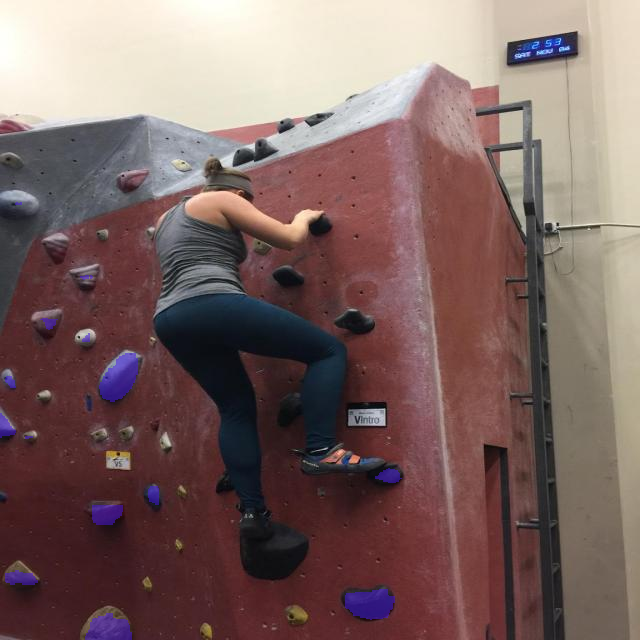